References:\
    https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/ (pickle)\
    https://towardsdatascience.com/coding-a-custom-imputer-in-scikit-learn-31bd68e541de(custom Imputer)

In [40]:
import pandas as pd
pd.set_option('display.max_columns', None)

import json
import numpy as np
import matplotlib.pyplot as plt
import pickle

# from pandas_profiling import ProfileReport

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, classification_report
import xgboost

import random
random.seed(42)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [17]:
from src.pandas_helper import *

**Note:** To speed up running of model fit cells, the n_jobs parameter is set to a global variable. This is defaulted to -1 to allow access to the entirety of your machine's CPU resources. This ***will*** make your machine essentially unusable until the operations have finished performing. Set this to None for regular operations

In [43]:
Notebook_n_jobs = -1

# Load Data

In [19]:
X = pd.read_csv('data/Training_set.csv')
y = pd.read_csv('data/Training_labels.csv').status_group

In [20]:
X.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


,Number,Percentage
,,
Zeroes,0,0.00 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,3,0.01 %
Mean,0.00,-
Median,0.00,-


,Value Count,% Value Count
functional,32259,54.308081
non functional,22824,38.424242
functional needs repair,4317,7.267677


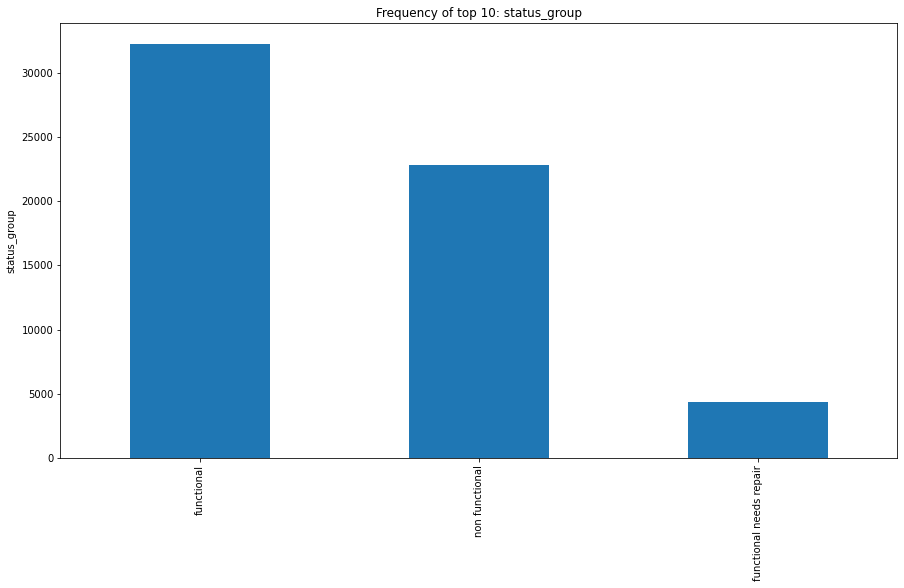

In [21]:
colInfo(y)

# Train Test Split

In [22]:
X_train,X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [23]:
y_train.value_counts()

functional                 24161
non functional             17146
functional needs repair     3243
Name: status_group, dtype: int64

In [24]:
y_test.value_counts()

functional                 8098
non functional             5678
functional needs repair    1074
Name: status_group, dtype: int64

# Pipelines

### GPS coordinates

In [25]:
X_train[['latitude','longitude']].value_counts()[:3]

latitude       longitude
-2.000000e-08  0.000000     1339
-6.980216e+00  39.096499       2
-7.056372e+00  37.375717       2
dtype: int64

In [26]:
X_test[['latitude','longitude']].value_counts()[:3]

latitude       longitude
-2.000000e-08  0.000000     473
-2.490324e+00  32.987670      2
-6.963557e+00  37.543351      2
dtype: int64

The data set has 1812 (inluding the test set) records where the latitude and longitude were not correctly recorded. They've been recorded as $(-2\times10^{-8},0)$ or effectively $(0,0)$ which is off the west coast of Africa in the Atlantic Ocean. All of these coordinates belong to 2 regions. We will use a custom imputer to impute these values during our pipeline operations.

In [27]:
from src.sklearn_helper import CoordinatesImputer

### construction_year

,Number,Percentage
,,
Zeroes,"15,463",34.71 %
Missing,0,0.00 %
Unknown,0,0.00 %
Uniques,55,0.12 %
Mean,1303.75,-
Median,1986.00,-


,Value Count,% Value Count
0,15463,34.709315
2010,2001,4.491582
2008,1959,4.397306
2009,1892,4.246914
2000,1595,3.580247
2007,1195,2.682379
2006,1103,2.475870
2003,989,2.219978
2011,943,2.116723
2012,839,1.883277


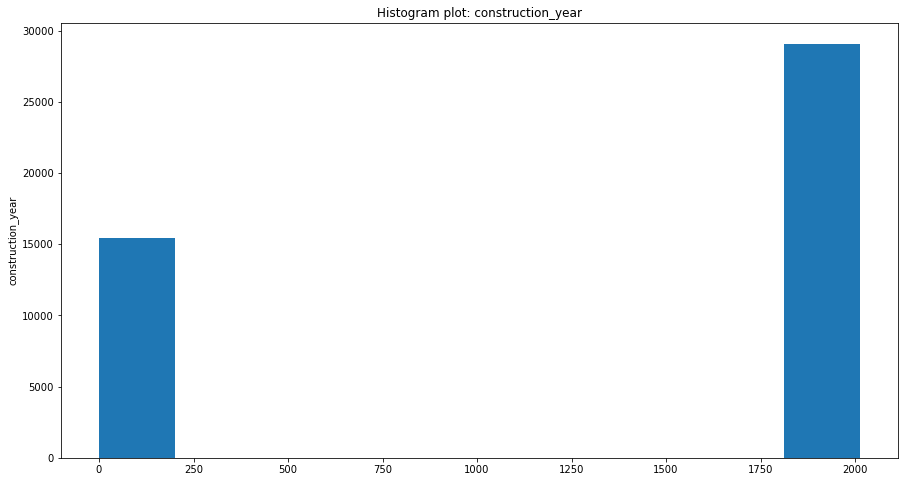

In [28]:
colInfo(X_train.construction_year)

Every well water pump has a construction year. However, as you can see in the training set there is a high number (34%) of zeroes. Assuming that this is an error and well water pumps were not being installed in 0AD, we shall impute these values using kNN imputer. Lets look at what the rest of the data looks like.

In [29]:
# enc_columnNames =  
# col_ImputeToMedian + \
# list(ct.transformers_[1][1]['cat1_ohe'].get_feature_names_out())  +\
# list(ct.transformers_[2][1]['cat2_ohe'].get_feature_names_out())

# X_train_proc = pd.DataFrame(ct.fit_transform(X_train,y_train),columns = enc_columnNames)
# X_test_proc = pd.DataFrame(ct.transform(X_test),columns = enc_columnNames)

# print(X_train_proc)
# print(X_test_proc)

### Transformations

In [30]:
#Impute nans as well as unknowns
subpipe_cat1 = Pipeline(steps=[
    ('cat1_imp1', SimpleImputer(missing_values=np.nan,strategy='most_frequent')),
    ('cat1_imp2', SimpleImputer(missing_values='unknown',strategy='most_frequent')),
    ('cat1_ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

#Only OneHotEncode
subpipe_cat2 = Pipeline(steps=[
    ('cat2_ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

#Impute mean and scale (0,1)
subpipe_num = Pipeline(steps=[
    ('num_imp', SimpleImputer(missing_values=np.nan,strategy='mean')),
    ('num_sc', MinMaxScaler()),    
])

#Impute (0,0) coordinates from the corresponding regions mean/median  and scale (0,1)
subpipe_coord = Pipeline(steps=[
    ('coord_imp', CoordinatesImputer(groupByTarget='region',metric='median')), 
    ('coord_sc', MinMaxScaler()),    
])

#kNN impute construction years = 0. scale (0,1)
subpipe_cYr = Pipeline(steps=[
    ('cYr_imp', KNNImputer(missing_values=0,n_neighbors=3)),
    ('cYr_sc', MinMaxScaler()),    
])

In [31]:
# These are columns that will be only One Hot Encoded
col_OneHotEncode = ['basin','extraction_type_class','management','payment','quality_group',
                    'quantity','source_type','waterpoint_type_group']

In [32]:
#These columns will be Imputed to fill in nan as well as 'unknown' to their mode
#Then they will be One Hot Encoded
col_ImputeAndOHE = ['public_meeting','scheme_management','permit','source_class']

# Models - Baselines

## Model 00 - Dummy Classifier

Using a dummy classifier to establish our baseline.\
Since, this classifier doesn ignores input variables, and in the interest of time, we will not employ our column transformation pipeline.

In [ ]:
baseline_00 = DummyClassifier()
baseline_00.fit(X_train,y_train)

cross_val_score(baseline_00,X_train,y_train).mean()

54%. Thats our dummy classifier baseline

In [ ]:
filePath = f'models/{baseline_00=}'.split('=')[0] + '.sav'
pickle.dump(baseline_00, open(filePath, 'wb'))

##  Model 01 - First Simple Model

In [34]:
ct = ColumnTransformer(transformers=[
    
    ('ct_cyr',subpipe_cYr,['construction_year']),
    ('ct_coord',subpipe_coord, ['latitude','longitude','region']), #Note: region is passed to allow groupby. Not returned.
    ('ct_cat1',subpipe_cat1,col_ImputeAndOHE),
    ('ct_cat2',subpipe_cat2,col_OneHotEncode),

])

In [38]:
log_reg_pipe = Pipeline([
    ('ct',ct),
   ('log_reg',LogisticRegression(random_state=42,n_jobs=Notebook_n_jobs))
])
log_reg_pipe.fit(X_train,y_train);

In [37]:
filePath = f'models/{log_reg_pipe=}'.split('=')[0] + '.sav'
pickle.dump(log_reg_pipe, open(filePath, 'wb'))

cross_val_score(log_reg_pipe,X_train,y_train).mean()

0.7297643097643097

72.97%. In conjunction with our column transformer a simple logistic regression model shows massive improvements over the baseline.

Lets try and tune it better.

C:\Users\saads\anaconda3\envs\learn-env\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


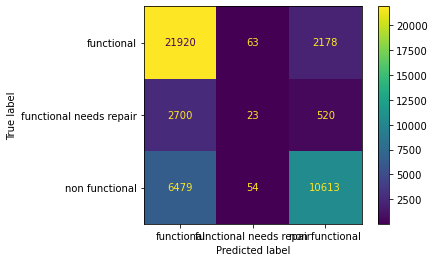

In [39]:
plot_confusion_matrix(log_reg_pipe,X_train,y_train)

In [42]:
print(classification_report(y_train,log_reg_pipe.predict(X_train)))

                         precision    recall  f1-score   support

             functional       0.70      0.91      0.79     24161
functional needs repair       0.16      0.01      0.01      3243
         non functional       0.80      0.62      0.70     17146

               accuracy                           0.73     44550
              macro avg       0.56      0.51      0.50     44550
           weighted avg       0.70      0.73      0.70     44550



### Hypertuned Logistic Regression model

In [ ]:
params = {}
params['log_reg__C'] = [0.1, 1, 10]
params['log_reg__max_iter'] = [100, 150]
params['log_reg__solver'] = ['lbfgs', 'sag']

log_reg_gs1 = GridSearchCV(estimator=log_reg_pipe,
                           param_grid=params,
                           cv=5,
                           n_jobs=Notebook_n_jobs,
                           scoring=['precision', 'accuracy'],
                           refit=False,
                           return_train_score=True)
log_reg_gs1.fit(X_train, y_train)

In [ ]:
filePath = f'models/{log_reg_gs1=}'.split('=')[0] + '.sav'
pickle.dump(log_reg_gs1, open(filePath, 'wb'))

log_reg_gs1.

# Iterative Models

In [ ]:
ct = ColumnTransformer(transformers=[
    
    ('ct_cyr',subpipe_cYr,['construction_year']),
    ('ct_coord',subpipe_coord, ['latitude','longitude','region']), #Note: region is passed to allow groupby. Not returned.
    ('ct_cat1',subpipe_cat1,col_ImputeAndOHE),
    ('ct_cat2',subpipe_cat2,col_OneHotEncode),
    
])

## Random Forest

In [ ]:
rfc_model_pipe = Pipeline([
   ('rfc',RandomForestClassifier(random_state=42))
])

rfc_model_pipe.fit(X_train,y_train)

cross_val_score(rfc_model_pipe,X_train,y_train,cv=5).mean()

In [ ]:
filePath = f'models/{rfc_model_pipe=}'.split('=')[0] + '.sav'
pickle.dump(rfc_model_pipe, open(filePath, 'wb'))

### Hypertuned Random Forest

#### Round 1

In [ ]:
params = {}
params['rfc__criterion'] = ['gini','entropy']
params['rfc__n_estimators'] = [150,200,250]
params['rfc__max_depth'] = [5,7,9]
rfc_gs1 = GridSearchCV(estimator=rfc_model_pipe,param_grid=params,cv=5)
rfc_gs1.fit(X_train,y_train)

In [ ]:
filePath = f'models/{rfc_gs1=}'.split('=')[0] + '.sav'
pickle.dump(rfc_gs1, open(filePath, 'wb'))

In [ ]:
rfc_gs1.best_estimator_

In [ ]:
rfc_gs1.best_score_

Seems like the model prefers the 'gini' impurity. Removing criterion for successive runs.

n_estimators and max_depth chose the highest value in range. Increasing range.

#### Round 2

In [ ]:
params = {}
params['rfc__n_estimators'] = [350,450,500]
params['rfc__max_depth'] = [15,20,30]

rfc_gs2 = GridSearchCV(estimator=rfc_model_pipe,param_grid=params,cv=5,n_jobs = 6)
rfc_gs2.fit(X_train,y_train)

In [ ]:
filePath = f'models/{rfc_gs2=}'.split('=')[0] + '.sav'
pickle.dump(rfc_gs2, open(filePath, 'wb'))

In [ ]:
rfc_gs2.best_estimator_

In [ ]:
rfc_gs2.best_score_

n_estimators and max_depth chose the highest value in range again. Increasing range.

#### Round 3

In [ ]:
params = {}
# params['rfc__criterion'] = ['gini','entropy']
params['rfc__n_estimators'] = [350,400,450]
params['rfc__max_depth'] = [22,25,30]
params['rfc__max_leaf_nodes']=[4000,4500,5000]

rfc_gs3 = GridSearchCV(estimator=rfc_model_pipe,param_grid=params,cv=5,n_jobs = -1)
rfc_gs3.fit(X_train,y_train)

In [ ]:
filePath = f'models/{rfc_gs3=}'.split('=')[0] + '.sav'
pickle.dump(rfc_gs3, open(filePath, 'wb'))

In [ ]:
rfc_gs3.best_estimator_

In [ ]:
rfc_gs3.best_score_

### Hypertuned and SMOTE Random Forest

In [ ]:
rfc_imb_model_pipe = ImPipeline([
    ('sm',SMOTE(random_state=42)),
   ('rfc',RandomForestClassifier(random_state=42))
])

rfc_imb_model_pipe.fit(X_train,y_train)
filePath = f'models/{rfc_imb_model_pipe=}'.split('=')[0] + '.sav'
pickle.dump(rfc_imb_model_pipe, open(filePath, 'wb'))

cross_val_score(rfc_imb_model_pipe,X_train,y_train,cv=5).mean()

#### Round 1

In [ ]:
params = {}
# params['rfc__criterion'] = ['gini','entropy']
params['rfc__n_estimators'] = [350,400,450]
params['rfc__max_depth'] = [22,25,30]
params['rfc__max_leaf_nodes']=[4000,4500,5000]

rfc_imb_gs1 = GridSearchCV(estimator=rfc_imb_model_pipe,param_grid=params,cv=5,n_jobs = -1)
rfc_imb_gs1.fit(X_train,y_train)

In [ ]:
filePath = f'models/{rfc_imb_gs1=}'.split('=')[0] + '.sav'
pickle.dump(rfc_imb_gs1, open(filePath, 'wb'))

In [ ]:
rfc_imb_gs1.best_estimator_

In [ ]:
rfc_imb_gs1.best_score_

## kNN

In [ ]:
knn_model_pipe = Pipeline([
   ('knn',KNeighborsClassifier())
])

knn_model_pipe.fit(X_train,y_train)
filePath = f'models/{knn_model_pipe=}'.split('=')[0] + '.sav'
pickle.dump(knn_model_pipe, open(filePath, 'wb'))

cross_val_score(knn_model_pipe,X_train,y_train,cv=5).mean()

### Hypertuned kNN

#### Round 1

In [ ]:
params = {}
params['knn__n_neighbors'] = [5,10,15,20]
params['knn__metric']=['manhattan','euclidean','chebyshev']

knn_gs1 = GridSearchCV(estimator=knn_model_pipe,param_grid=params,cv=5,n_jobs = -1)
knn_gs1.fit(X_train,y_train)

In [ ]:
filePath = f'models/{knn_gs1=}'.split('=')[0] + '.sav'
pickle.dump(knn_gs1, open(filePath, 'wb'))

In [ ]:
knn_gs1.best_estimator_

In [ ]:
knn_gs1.best_score_

#### Round 2

In [ ]:
params = {}
params['knn__n_neighbors'] = [3,4,5,6,7]
params['knn__metric']=['manhattan','euclidean','chebyshev']

knn_gs2 = GridSearchCV(estimator=knn_model_pipe,param_grid=params,cv=5,n_jobs = -1)
knn_gs2.fit(X_train,y_train)

In [ ]:
filePath = f'models/{knn_gs2=}'.split('=')[0] + '.sav'
pickle.dump(knn_gs2, open(filePath, 'wb'))

In [ ]:
knn_gs2.best_estimator_

In [ ]:
knn_gs2.best_score_

### Hypertuned SMOTE KNN


In [ ]:
knn_imb_model_pipe = ImPipeline([
    ('sm',SMOTE(random_state=42)),
   ('knn',KNeighborsClassifier())
])

knn_imb_model_pipe.fit(X_train,y_train)
filePath = f'models/{knn_imb_model_pipe=}'.split('=')[0] + '.sav'
pickle.dump(knn_imb_model_pipe, open(filePath, 'wb'))

cross_val_score(knn_imb_model_pipe,X_train,y_train,cv=5).mean()

## XGBoost

In [ ]:
XGBRF_model_pipe = Pipeline([
   ('xg',xgboost.XGBRFClassifier(random_state=42))
])

XGBRF_model_pipe.fit(X_train,y_train)
filePath = f'models/{XGBRF_model_pipe=}'.split('=')[0] + '.sav'
pickle.dump(XGBRF_model_pipe, open(filePath, 'wb'))

cross_val_score(XGBRF_model_pipe,X_train,y_train,cv=5).mean()

### Hypertuned XGBoost

#### Round 1

In [ ]:
params = {}
params['xg__learning_rate'] = [0.001,0.1,1,10,100]
params['xg__reg_lambda'] = [1e-06,1e-05,1e-04,1e-03,1e-02]

xgbrf_gs1 = GridSearchCV(estimator=XGBRF_model_pipe,param_grid=params,cv=5,n_jobs = -1)
xgbrf_gs1.fit(X_train,y_train)

In [ ]:
filePath = f'models/{xgbrf_gs1=}'.split('=')[0] + '.sav'
pickle.dump(xgbrf_gs1, open(filePath, 'wb'))

In [ ]:
xgbrf_gs1.best_estimator_

In [ ]:
xgbrf_gs1.best_score_